In [2]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### file hierarchy and database connection vars

In [3]:
# directory & file hierarchy
iterationName = 'Bingphotodraw_e1'
exp_path = 'photodraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [4]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['Bing_photodraw_e1']


### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [5]:
# experiment_name = 'Bingphotodraw_pilot'
experiment_name = 'Bing_photodraw_e1'

all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find().distinct('sessionId')
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)


We currently have 16 valid sessions from Bing_photodraw_e1.


In [14]:
really_run_this = 1
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    kidName = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    countErr = 0
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:                                                            
                stroke_recs = this_collection.find({'$and': [ 
                                                  {'sessionId':s}, 
                                                  {'dataType':'stroke'},
                                                  {'trialNum': imrec['trialNum']}]}).sort('time')   

                if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                    session_id.append(imrec['sessionId'])        
                    trial_num.append(imrec['trialNum']) 
                    category.append(imrec['category'])
                    
                    
                    try:    
                        png.append(imrec['imgData'])
                        submit_time.append(imrec['time'])
                        submit_date.append(imrec['date'])
                        filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'], imrec['subID'],imrec['sessionId'], imrec['condition'])))
                        num_strokes.append(stroke_recs.count())
                        _svg = [] # this keeps track of the strokes from THIS final image
                        _svg_times = []
                        for strec in stroke_recs:
                            _svg.append(strec['svg'])
                            _svg_times.append(strec['time'])
                        draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                        svg.append(_svg)
                        svg_times.append(_svg_times)

                        ## and write out image data here too
                        imgData = imrec['imgData'];
                        filestr = base64.b64decode(imgData)
                        child_dir = os.path.join(sketch_dir,imrec['subID'])
                        if not os.path.exists(child_dir):
                            os.makedirs(child_dir)
                        fname = os.path.join(child_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'], imrec['subID'],imrec['sessionId'],imrec['condition']))
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))  
                    except:
                        print('something went wrong with an image')
                        countErr = countErr + 1
                        print imrec['category']
                        child_dir = os.path.join(sketch_dir,'noname')
                        if not os.path.exists(child_dir):
                            os.makedirs(child_dir)
                        fname = os.path.join(child_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], 'noname',imrec['sessionId']))
                        with open(fname, "wb") as fh:
                            fh.write(imgData.decode('base64'))  
                        

In [7]:
imrec

{u'_id': ObjectId('5b4e2e5e07aab50b0de2e7e7'),
 u'category': u'cat',
 u'condition': u'S',
 u'counter_balancing': u'1',
 u'dataType': u'finalImage',
 u'date': u'2018-07-17T17:58:54.022Z',
 u'imgData': u'iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAYAAAA8AXHiAAAAAXNSR0IArs4c6QAAAaFJREFUeAHt0DEBAAAAwqD1T20LL4hAYcCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQMGDBgwYMCAAQO/gQFgNQAB6po22QAAAABJRU5ErkJggg==',
 u'kidName': u'MASON PHILLIPS ',
 u'location': u'Bing',
 u'sessionId': u'Bing_photodraw_e11531846929758',
 u'subID': u'Sub07',
 u'time': 153185

In [9]:
if really_run_this:
    X = pd.DataFrame([session_id,trial_num,category,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','trial_num','category','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'filename']



In [10]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat

190
[12, 16, 18, 18, 17, 4, 18, 16, 14, 17, 18, 6, 16]


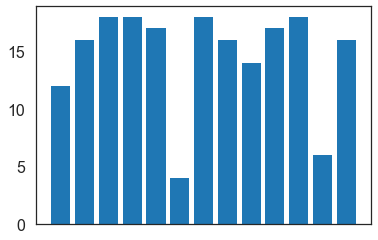

In [11]:
plt.bar(categories,ims_per_cat)
frame1=plt.gca()
frame1.axes.get_xaxis().set_visible(False)


In [ ]:
X_out.draw_duration

### load drawing metadata csv back in

### Basic visualizations

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.num_strokes.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('number of strokes')

In [ ]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(X.draw_duration.values,normed=True)
plt.ylabel('proportion')
plt.xlabel('draw duration')

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes',order=seq,palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration',order=seq, palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

In [ ]:
X.category

In [ ]:
unique = X.drop_duplicates(["session_id"])
unique.count()
# sum(unique.age != 'adult')
sum(unique.age != 'adult')

In [ ]:
X.

In [ ]:
unique

In [ ]:
categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
num_ims = 0
ims_per_cat = []
for c in categories:
    num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
    ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
print num_ims
print ims_per_cat